In [1]:
!pip install torchsummary

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.manual_seed(0)

In [4]:
BATCH_SIZE = 128

transform = transforms.Compose([
    transforms.ToTensor(),
])


trainval_dataset = datasets.MNIST('./', train=True, download=True, transform=transform) # range 0-1
test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform) # range 0-1
train_size = int(len(trainval_dataset) * 0.8)
val_size = int(len(trainval_dataset) * 0.2)
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

0it [00:00, ?it/s]

9920512it [00:01, 8564485.13it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 134742.49it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2193988.46it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 50077.01it/s]            


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
48000
12000
10000


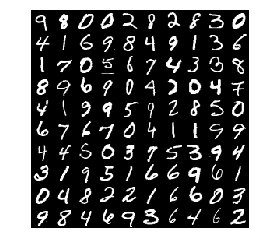

tensor([[9, 8, 0, 0, 2, 8, 2, 8, 3, 0],
        [4, 1, 6, 9, 8, 4, 9, 1, 3, 6],
        [1, 7, 0, 5, 6, 7, 4, 3, 3, 8],
        [8, 9, 6, 9, 0, 4, 2, 0, 4, 7],
        [4, 1, 9, 9, 5, 9, 2, 8, 5, 0],
        [6, 7, 6, 7, 0, 4, 1, 1, 9, 9],
        [4, 4, 5, 0, 3, 7, 5, 3, 9, 4],
        [3, 1, 9, 5, 1, 6, 6, 9, 6, 1],
        [0, 4, 8, 2, 2, 1, 6, 6, 0, 3],
        [9, 8, 4, 6, 9, 3, 6, 4, 6, 2]])


In [5]:
def show_img(x):
    if hasattr(x, 'numpy'):
        x = x.numpy()
    x = x.transpose((1, 2, 0))
    x = np.squeeze(x)
    plt.imshow(x)
    plt.axis('off')
    plt.show()
    
imgs, labels = iter(train_loader).next()
imgs = imgs[:100]
labels = labels[:100]

show_img(torchvision.utils.make_grid(imgs, nrow=10, padding=0))
print(labels.view(10,10))

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [0]:
def train(model, device, optimizer, criterion, train_loader, preprocess=None):
    model.train()
    total = 0
    running_loss = 0
    correct = 0
    
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        
        if preprocess:
            imgs = preprocess(imgs)
        
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
    
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        pred = outputs.argmax(dim=1)
        correct += (pred == labels).sum().item()
        running_loss += loss.item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)

    return {'acc':train_acc, 'loss':train_loss}

In [0]:
def validation(model, device, criterion, val_loader, preprocess=None):
    model.eval()
    runnning_loss = 0
    correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            if preprocess:
                imgs = preprocess(imgs)
                
            imgs, labels = imgs.to(device), labels.to(device)
            
            output = model(imgs)
            
            runnning_loss += criterion(output, labels).item()
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()

    val_loss = runnning_loss / len(val_loader)
    val_acc = correct / len(val_loader.dataset)

    return {'acc':val_acc, 'loss':val_loss}

In [0]:
def run(epochs, model, device, optimizer, criterion, train_loader, test_loader, preprocess=None):
    history = {'train_acc':[], 'train_loss':[], 'val_acc':[], 'val_loss':[]}

    for epoch in range(1, epochs+1):
        train_ret = train(model, device, optimizer, criterion, train_loader, preprocess=preprocess)
        val_ret = validation(model, device, criterion, test_loader, preprocess=preprocess)
        
        print("Epoch:{} train_acc:{:.4f} train_loss:{:.4f} val_acc:{:.4f} val_loss:{:.4f}".format(
            epoch, train_ret['acc'], train_ret['loss'], val_ret['acc'], val_ret['loss']))

        history['train_acc'].append(train_ret['acc'])
        history['train_loss'].append(train_ret['loss'])
        history['val_acc'].append(val_ret['acc'])
        history['val_loss'].append(val_ret['loss'])
    
    return history

In [10]:
model = Net(input_size=784, hidden_size=10, output_size=10)

from torchsummary import summary
summary(model, input_size=(1, 784),  device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]           7,850
            Linear-2                [-1, 1, 10]             110
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [11]:
def preprocess(x):
    return x.view(-1, 784)

epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.NLLLoss()

print("device:",device)

model = model.to(device)
history = run(epochs, model, device, optimizer, criterion, train_loader, val_loader, preprocess=preprocess)

device: cuda


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


Epoch:1 train_acc:0.7601 train_loss:0.8201 val_acc:0.8760 val_loss:0.4326
Epoch:2 train_acc:0.8868 train_loss:0.3920 val_acc:0.8986 val_loss:0.3633
Epoch:3 train_acc:0.8982 train_loss:0.3528 val_acc:0.9033 val_loss:0.3449
Epoch:4 train_acc:0.9043 train_loss:0.3331 val_acc:0.9069 val_loss:0.3336
Epoch:5 train_acc:0.9081 train_loss:0.3186 val_acc:0.9115 val_loss:0.3200
Epoch:6 train_acc:0.9114 train_loss:0.3082 val_acc:0.9110 val_loss:0.3155
Epoch:7 train_acc:0.9140 train_loss:0.2992 val_acc:0.9128 val_loss:0.3099
Epoch:8 train_acc:0.9172 train_loss:0.2904 val_acc:0.9192 val_loss:0.2975
Epoch:9 train_acc:0.9195 train_loss:0.2830 val_acc:0.9194 val_loss:0.2905
Epoch:10 train_acc:0.9220 train_loss:0.2756 val_acc:0.9210 val_loss:0.2874
Epoch:11 train_acc:0.9241 train_loss:0.2694 val_acc:0.9216 val_loss:0.2815
Epoch:12 train_acc:0.9250 train_loss:0.2632 val_acc:0.9235 val_loss:0.2768
Epoch:13 train_acc:0.9266 train_loss:0.2583 val_acc:0.9243 val_loss:0.2744
Epoch:14 train_acc:0.9293 train_lo

In [0]:
save_model = True
if (save_model):
    torch.save(model.state_dict(),"mnist.pt")

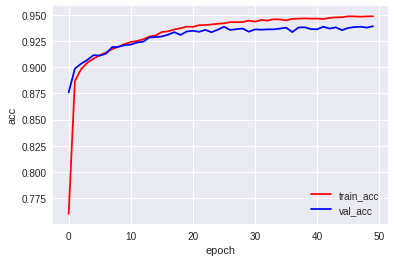

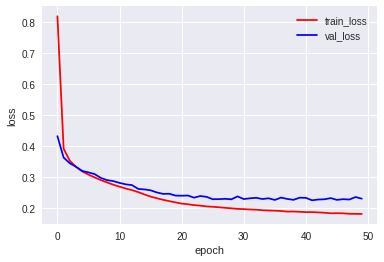

In [13]:
def plot_history(history):
    
    epochs = len(history['train_acc'],)
    
    xaxis = range(epochs)
    plt.figure()
    plt.plot(xaxis, history['train_acc'], 'r-', label='train_acc')
    plt.plot(xaxis, history['val_acc'], 'b-', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')


    plt.figure()
    plt.plot(xaxis, history['train_loss'], 'r-', label='train_loss')
    plt.plot(xaxis, history['val_loss'], 'b-', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')

plot_history(history)

In [0]:
def predict(model, device, img):
    img = img.to(device)
    pred = model(img)
    pred = torch.argmax(pred).item()
    return pred

resutl:True   pred:6   label6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


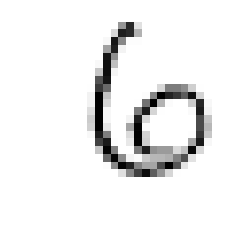

In [15]:
img, label = test_dataset[100]

model = model.to(device)
pred = predict(model, device, preprocess(img))
print("resutl:{}   pred:{}   label{}".format(pred==label, pred, label))

show_img(img)

In [16]:
def test(model, classes, device, criterion, test_loader, preprocess=None):
    outsize = len(classes)
    class_correct = list(0. for i in range(outsize))
    class_total = list(0. for i in range(outsize))
    runnning_loss = 0
    with torch.no_grad():
        for data in test_loader:
            imgs, labels = data
            if preprocess:
                imgs = preprocess(imgs)
            n_batch = imgs.size(0)
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            runnning_loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, 1)
            c = (pred == labels).squeeze()
            for i in range(n_batch):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        
    test_acc = int(sum(class_correct)/sum(class_total)*100)
    test_loss = runnning_loss / len(test_loader)
    print('acc  : {:2d}%'.format(test_acc))
    print('loss : {:.4f}'.format(test_loss) )


    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)
model = model.to(device)
test(model, classes, device, criterion, test_loader, preprocess=preprocess)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


device: cuda
Accuracy of     0 : 97 %
Accuracy of     1 : 97 %
Accuracy of     2 : 94 %
Accuracy of     3 : 93 %
Accuracy of     4 : 94 %
Accuracy of     5 : 91 %
Accuracy of     6 : 93 %
Accuracy of     7 : 93 %
Accuracy of     8 : 90 %
Accuracy of     9 : 89 %
acc  : 93%
loss : 0.2152


In [17]:
state_dict = model.state_dict()
state_dict

OrderedDict([('fc1.weight',
              tensor([[-0.0333,  0.0091,  0.0266,  ...,  0.0123,  0.0241,  0.0147],
                      [-0.0021, -0.0201,  0.0025,  ..., -0.0138, -0.0337, -0.0199],
                      [ 0.0283,  0.0176,  0.0078,  ...,  0.0282,  0.0161, -0.0294],
                      ...,
                      [-0.0275, -0.0003,  0.0308,  ...,  0.0353,  0.0205, -0.0067],
                      [-0.0128,  0.0301,  0.0349,  ..., -0.0119, -0.0259, -0.0035],
                      [ 0.0225, -0.0047, -0.0087,  ..., -0.0323,  0.0179,  0.0230]],
                     device='cuda:0')),
             ('fc1.bias',
              tensor([-0.0782, -0.1163, -0.4783,  0.6073, -1.0728, -0.3974, -0.1033,  0.7079,
                      -0.4626,  0.3918], device='cuda:0')),
             ('fc2.weight',
              tensor([[-1.4353e+00, -9.3932e-02,  1.1769e+00, -6.4370e-01,  5.5779e-01,
                        1.5819e+00, -3.0059e-01, -1.0923e-01,  3.7888e-01,  2.2323e-02],
               

(10, 784)
(10, 1, 28, 28)


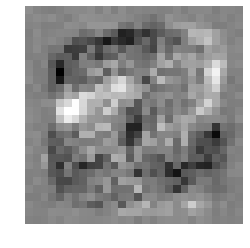

In [18]:
w = state_dict["fc1.weight"].to('cpu').numpy()
print(w.shape)

weights = np.zeros((w.shape[0], 1, 28, 28))
for i, w_ in enumerate(w):
    weights[i] = w_.reshape(1, 28,28)

print(weights.shape)

show_img(weights[0])